# Data Pre-Processing

In [1]:
import os
import pathlib

import pandas as pd

In [2]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "clean_data", "cleaned_data.csv")

data = pd.read_csv(data_path)
data.head()

,img_idx,labels,age,gender,view_pos,label_cardiomegaly,label_effusion,label_no_finding,label_pneumothorax,label_pleural_thickening,label_pneumonia,label_consolidation,label_other
0,00000001_000.png,Cardiomegaly,58,M,PA,True,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,True,True,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,False,False,True,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,False,False,False,False,False,False,False,True


In [3]:
label_names = [l for l in data.columns if l.startswith("label_")]
label_names

['label_cardiomegaly',
 'label_effusion',
 'label_no_finding',
 'label_pneumothorax',
 'label_pleural_thickening',
 'label_pneumonia',
 'label_consolidation',
 'label_other']

In [4]:
label_counts_sorted = data[label_names].sum(axis=0).sort_values()
label_counts_sorted

label_pneumonia              1430
label_cardiomegaly           2776
label_pleural_thickening     3384
label_consolidation          4667
label_pneumothorax           5301
label_effusion              13316
label_other                 39770
label_no_finding            60353
dtype: int64

We want to have a balanced dataset that contains an equal number of examples of each condition (+"no finding"), regardless of 'overlaps' (i.e. multiple conditions).  

We will start from the lowest common denominator, i.e. the condition with the fewest number of examples, i.e. pnemonia. We will choose **all** of the pneumonia cases, `N0 = N_pneumonia = 1430` above. Then we have to choose the same number of examples from each of the other conditions, in increasing order of the number of cases. But there are overlaps, so we will exclude cases already chosen from previous labels (i.e. those with fewer examples). We will keep adding examples until we have `N0` rows with each label.  

Note that `label_other` will have no overlap with any other label.

In [34]:
rarest_label = label_counts_sorted.index[0]
rarest_label_count = data[data[rarest_label]].shape[0]
data_balanced = data[data[rarest_label]]
n_min = data_balanced.shape[0]

for label, count in zip(label_counts_sorted.index[1:], label_counts_sorted[1:]):
    n_already_captured = data_balanced[data_balanced[label]].shape[0]
    n_additional = n_min - n_already_captured
    if n_additional > 0:
        not_selected_indices = data.index.difference(data_balanced.index)
        not_selected_data = data.loc[not_selected_indices]
        rows_to_add = not_selected_data[not_selected_data[label]].sample(n_additional)
        data_balanced = pd.concat([data_balanced, rows_to_add], axis=0)

data_balanced[label_names].sum(axis=0).sort_values()

label_no_finding            1430
label_pneumothorax          1430
label_pneumonia             1430
label_consolidation         1463
label_cardiomegaly          1473
label_pleural_thickening    1503
label_effusion              1624
label_other                 3427
dtype: int64

Actually let's keep a small percentage of the rarest class (pneumonia) for testing...

In [49]:
rarest_label_pct_to_keep = 0.1
indices_to_remove = (
    data_balanced[data_balanced[rarest_label]]
    .sample(int(rarest_label_count * rarest_label_pct_to_keep))
    .index
)
data_balanced.drop(indices_to_remove, inplace=True)

In [50]:
data_balanced.shape

(7766, 13)

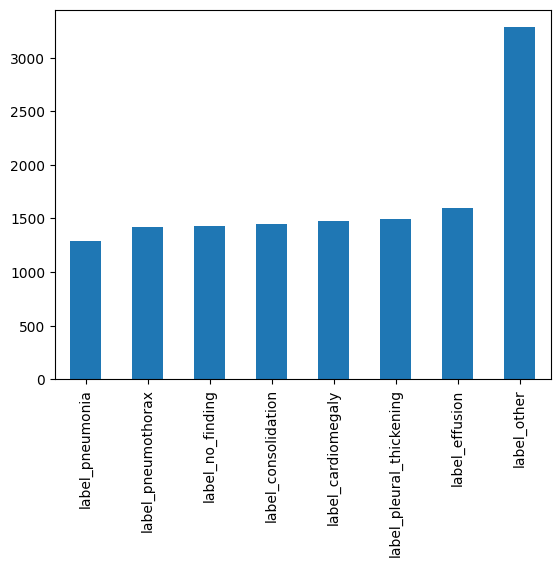

In [51]:
data_balanced[label_names].sum(axis=0).sort_values().plot(kind="bar");

We can use the remaining (i.e. not selected) data for our test set later on...

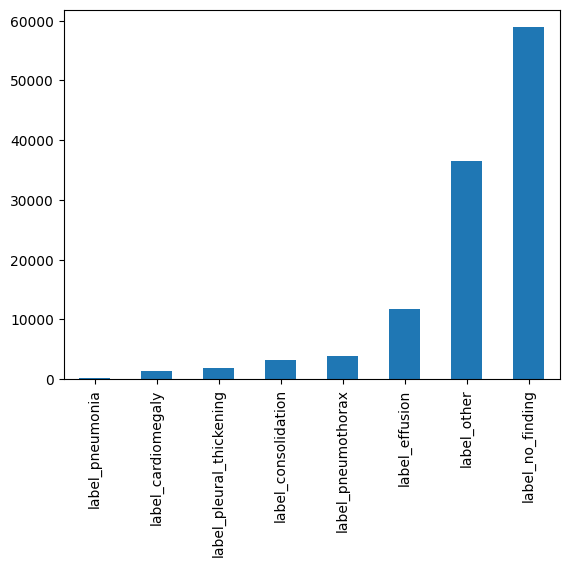

In [53]:
remaining_indices = data.index.difference(data_balanced.index)
remaining_data = data.loc[remaining_indices]
remaining_data[label_names].sum(axis=0).sort_values().plot(kind="bar");

In [52]:
# TO DO: Try to prioritize Posterior-Anterior (PA) projection when building a balanced dataset
# data_balanced.view_pos.value_counts().plot(kind="bar");

# Loading the Images

There are two ways to go about this:
1. Load the entire data set in memory if we have enough RAM, which we do. We estimate ~8000 images will take up between 4 to 8 gigabytes in RAM.
2. "Dataset generator": Keras has an "[image data generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)".

## Loading the Entire Dataset

Let's try the first method first...

In [9]:
import os
import pathlib

import numpy as np
import PIL

In [10]:
def load_img(img_filename):
    data_dir = pathlib.Path("../raw_data/images")
    image_filename = img_filename
    image = PIL.Image.open(pathlib.Path(data_dir, image_filename))
    return image

In [11]:
n_images = data_balanced.shape[0]
example_img = load_img(data_balanced.iloc[0, :]["img_idx"])
img_dims = example_img.size
img_dims

(1024, 1024)

In [12]:
img_data = np.zeros((n_images, *img_dims))
img_data.shape

(7903, 1024, 1024)

In [13]:
# # This crashes Jupyter Notebook
# for img in data_balanced.loc[:, "img_idx"]:
#     # np.append(img_data, load_img(img))
#     pass

That was a dud. It crashes Jupyter Notebook. Let us now explore the second method.

## Generating the Dataset on the Fly

It turns out [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is deprecated and hence not recommended for new code. Its successor, [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) is unfortunately not really applicable to our multi-label problem. I found [this blog post](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72) on how to leverage the underlying API, [`tf.data`](https://www.tensorflow.org/guide/data) for multi-label problems. Let us explore that.

In [14]:
import tensorflow as tf

In [15]:
IMG_SIZE = img_dims[0]
CHANNELS = 1  # The images are grayscale


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = (
        image_decoded  # tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    )
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = tf.cast(image_resized, tf.float32) / 255.0
    label_tensor = tf.convert_to_tensor(label, dtype=tf.uint8)
    return image_normalized, label_tensor

In [70]:
cwd = os.getcwd()
data_dir = pathlib.Path(cwd, "..", "raw_data", "images")

# This works
img_norm, label_tensor = parse_function(
    str(pathlib.Path(data_dir, "00030805_000.png")),
    np.array([True, False, False, True]) + 0,
)

In [17]:
# # This works too... So far so good.
# for index, row in data_balanced.iterrows():
#     img_path = str(pathlib.Path(data_dir, row.img_idx))
#     label_set_binarized = np.array(row[label_names]) + 0
#     parse_function(img_path, label_set_binarized)

In [84]:
BATCH_SIZE = 256  # Big enough to measure an F1-score
AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 1024  # Shuffle the training data by a chunck of 1024 observations

N_LABELS = len(label_names)

In [19]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [64]:
filenames = data_balanced.img_idx.to_list()
label_sets_binarized = np.array(
    data_balanced[label_names].apply(lambda x: x + 0), dtype=np.uint8
)

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_bin, y_val_bin = train_test_split(
    filenames, label_sets_binarized, test_size=0.2
)

In [66]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

We now, finally, have our training and validation data sets with the correct tensor sizes and data types.  
Now let's create the test set from the data that was _not_ selected while creating the balanced dataset. (Stored in `remaining_data`)

In [68]:
X_test = remaining_data.img_idx.to_list()
y_test_bin = np.array(
    remaining_data[label_names].apply(lambda x: x + 0), dtype=np.uint8
)

# Modelling

Let us first attempt to get a generic custom CNN working just as a sanity check.

In [85]:
def load_own_model():
    model = tf.keras.models.Sequential()

    # model.add(, input_shape=(256, 256, 3))

In [ ]:
# model = tf.keras.Sequential(
#     [
#         feature_extractor_layer,
#         layers.Dense(1024, activation="relu", name="hidden_layer"),
#         layers.Dense(N_LABELS, activation="sigmoid", name="output"),
#     ]
# )